In [262]:
import numpy as np
import pandas as pd
pd.set_option('max_rows',38)
pd.set_option('max_columns',25)
import time
import pickle
from tqdm import tqdm
import myslack_incomming

# model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils
from keras.layers import Activation, BatchNormalization
import xgboost
from scipy.sparse import csr_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn import preprocessing


# Ver 1

# Data Check

#### - train.csv

In [127]:
train = pickle.load(open("./data/final_train_Ver1.pkl", "rb"))
print("test data shape: "+str(train.shape))

test data shape: (95674, 5482)


#### - test.csv

In [109]:
test = pickle.load(open("./data/final_test_Ver1.pkl", "rb"))
print("test data shape: "+str(test.shape))

test data shape: (95674, 5481)


#### - sample_submission.csv

In [110]:
samplesub = pd.read_csv("./data/sample_submission.csv")
print("sample_submission data shape: "+str(samplesub.shape))

sample_submission data shape: (95674, 39)


---

# Modeling 8 - Neural Network

### Train_X, Train_y

In [258]:
X = train.drop(columns='TripType')
y = train['TripType']

In [259]:
len(y.unique()), y.unique()

(38, array([50, 30, 26,  8, 35, 41, 21,  6, 42,  7,  9, 39, 25, 38, 15, 36, 20,
        37, 32, 40,  5,  3,  4, 24, 33, 43, 31, 27, 34, 18, 29, 44, 19, 23,
        22, 28, 14, 12]))

In [260]:
y.unique()

array([50, 30, 26,  8, 35, 41, 21,  6, 42,  7,  9, 39, 25, 38, 15, 36, 20,
       37, 32, 40,  5,  3,  4, 24, 33, 43, 31, 27, 34, 18, 29, 44, 19, 23,
       22, 28, 14, 12])

In [263]:
preprocessing.LabelEncoder().fit_transform(y.unique())

array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
       29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
       14, 20,  8,  7])

In [264]:
train['TripType'].replace(y.unique(),preprocessing.LabelEncoder().fit_transform(y.unique()),inplace=True)

In [265]:
len(y.unique()), y.unique()

(38, array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
        29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
        14, 20,  8,  7]))

In [266]:
X = csr_matrix(X); X

<95674x5481 sparse matrix of type '<class 'numpy.int64'>'
	with 1124112 stored elements in Compressed Sparse Row format>

In [279]:
csr_test = csr_matrix(test); test

<95674x5481 sparse matrix of type '<class 'numpy.int64'>'
	with 1130483 stored elements in Compressed Sparse Row format>

## Keras

### Train Test Split

In [380]:
X_train, X_test, y_train0, y_test0 = train_test_split(X, y, test_size=0.15)

X_train.shape[0], X_test.shape[0], len(y_train0), len(y_test0)

(81322, 14352, 81322, 14352)

In [381]:
Y_train = np_utils.to_categorical(y_train0, 38)
Y_test = np_utils.to_categorical(y_test0, 38)

In [382]:
dense = 500
lr = 0.05

In [383]:
NN_model_Adadelta = Sequential()
NN_model_Adadelta.add(Dense(dense, input_dim=5481, kernel_initializer="glorot_uniform"))
NN_model_Adadelta.add(BatchNormalization())
NN_model_Adadelta.add(Activation('relu'))
NN_model_Adadelta.add(Dense(38, activation="softmax", kernel_initializer="glorot_uniform"))
NN_model_Adadelta.compile(optimizer=Adadelta(lr=lr), loss='categorical_crossentropy', metrics=["accuracy"])

In [384]:
NN_model_Adadelta.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 500)               2741000   
_________________________________________________________________
batch_normalization_17 (Batc (None, 500)               2000      
_________________________________________________________________
activation_17 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 38)                19038     
Total params: 2,762,038
Trainable params: 2,761,038
Non-trainable params: 1,000
_________________________________________________________________


In [385]:
epochs = 100
batch_size = 3000

In [386]:
%%time
hist = NN_model_Adadelta.fit(X_train, Y_train, 
                              epochs=epochs, batch_size=batch_size, 
                              validation_data=(X_test, Y_test), 
                              verbose=1)

myslack_incomming.send_slack('NN_model_Adadelta finish! den: {}, lr: {},  val_acc: {} '
                             .format(dense,lr,hist.history['val_acc'][-1]))

Train on 81322 samples, validate on 14352 samples
Epoch 1/100
81322/81322 [==============================] - 12s 145us/step - loss: 3.6016 - acc: 0.0528 - val_loss: 3.2606 - val_acc: 0.1215
Epoch 2/100
81322/81322 [==============================] - 10s 127us/step - loss: 3.0002 - acc: 0.2417 - val_loss: 2.9189 - val_acc: 0.2938
Epoch 3/100
81322/81322 [==============================] - 11s 134us/step - loss: 2.6343 - acc: 0.3528 - val_loss: 2.6534 - val_acc: 0.3926
Epoch 4/100
81322/81322 [==============================] - 12s 153us/step - loss: 2.3684 - acc: 0.4270 - val_loss: 2.4272 - val_acc: 0.4516
Epoch 5/100
81322/81322 [==============================] - 12s 150us/step - loss: 2.1616 - acc: 0.4786 - val_loss: 2.2391 - val_acc: 0.4995
Epoch 6/100
81322/81322 [==============================] - 12s 144us/step - loss: 1.9922 - acc: 0.5262 - val_loss: 2.0805 - val_acc: 0.5344
Epoch 7/100
81322/81322 [==============================] - 12s 152us/step - loss: 1.8500 - acc: 0.5634 - val_l

Epoch 59/100
81322/81322 [==============================] - 13s 158us/step - loss: 0.7219 - acc: 0.7760 - val_loss: 0.8917 - val_acc: 0.7177
Epoch 60/100
81322/81322 [==============================] - 13s 162us/step - loss: 0.7159 - acc: 0.7778 - val_loss: 0.8884 - val_acc: 0.7198
Epoch 61/100
81322/81322 [==============================] - 12s 150us/step - loss: 0.7107 - acc: 0.7794 - val_loss: 0.8861 - val_acc: 0.7206
Epoch 62/100
81322/81322 [==============================] - 13s 156us/step - loss: 0.7050 - acc: 0.7812 - val_loss: 0.8841 - val_acc: 0.7184
Epoch 63/100
81322/81322 [==============================] - 12s 146us/step - loss: 0.6994 - acc: 0.7832 - val_loss: 0.8812 - val_acc: 0.7200
Epoch 64/100
81322/81322 [==============================] - 12s 144us/step - loss: 0.6940 - acc: 0.7845 - val_loss: 0.8777 - val_acc: 0.7209
Epoch 65/100
81322/81322 [==============================] - 12s 146us/step - loss: 0.6888 - acc: 0.7862 - val_loss: 0.8748 - val_acc: 0.7230
Epoch 66/100


### Confusion Matrix

In [387]:
Y_test.argmax(axis=1)

array([24,  0, 30, ..., 14, 29, 16])

In [388]:
y_pred = NN_model_Adadelta.predict_classes(X_test)
confusion_matrix(Y_test.argmax(axis=1), y_pred)

array([[ 556,    0,    3, ...,    0,    0,    7],
       [   0,   41,    7, ...,    0,    0,    1],
       [   1,    0,  567, ...,    0,    0,    3],
       ...,
       [   1,    0,    6, ...,    8,    2,    1],
       [   0,    0,    0, ...,    6,   53,    0],
       [  43,    1,    9, ...,    0,    0, 1066]])

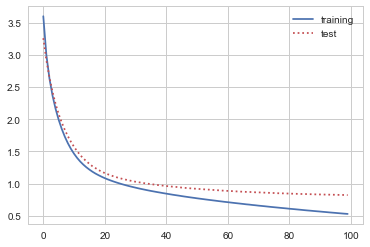

In [392]:
plt.plot(hist.history['loss'], 'b-', label="training")
plt.plot(hist.history['val_loss'], 'r:', label="test")
plt.legend()
plt.show()

In [393]:
'val_acc: '+str(hist.history['val_acc'][-1])

'val_acc: 0.7377369043021696'

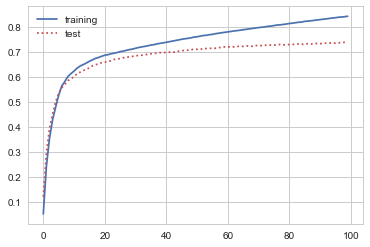

In [394]:
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

### prediction

In [395]:
result = NN_model_Adadelta.predict_proba(csr_test)
result

array([[1.5536369e-05, 4.3526976e-05, 1.6181567e-03, ..., 1.0509588e-03,
        3.8428709e-03, 2.9214213e-04],
       [7.3488351e-08, 3.7524137e-07, 6.8304803e-06, ..., 2.2696002e-04,
        1.6893492e-04, 2.8734311e-07],
       [2.3530467e-04, 3.8964188e-04, 1.5090121e-03, ..., 3.7056063e-03,
        1.4520534e-03, 1.7130629e-03],
       ...,
       [1.7314820e-03, 5.1438888e-03, 2.0778393e-02, ..., 3.7511352e-03,
        8.1621262e-04, 2.9003533e-02],
       [1.3436707e-11, 3.8105845e-11, 2.5414562e-09, ..., 1.1921629e-06,
        5.9103368e-05, 3.9776750e-12],
       [6.7448632e-08, 1.4521852e-07, 7.8552584e-06, ..., 2.3152826e-03,
        1.9405508e-02, 1.0880166e-08]], dtype=float32)

### Make Submission CSV file

In [396]:
subform_df_columns = samplesub.columns[1:]
result_df = pd.DataFrame(result)
result_df.columns = subform_df_columns
subform_df = pd.concat([test.reset_index()['VisitNumber'],result_df],axis=1)
subform_df.set_index('VisitNumber',inplace=True)
subform_df.tail()

,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,TripType_18,TripType_19,...,TripType_34,TripType_35,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,
191338,4.334320e-10,9.216717e-09,1.578179e-06,6.401921e-07,4.677436e-06,4.288371e-13,7.308071e-15,2.013786e-06,4.164234e-08,2.537585e-05,1.296265e-07,1.024818e-07,...,3.849048e-06,0.266060,2.528295e-04,5.745534e-05,0.001781,0.425455,0.027743,5.642170e-07,5.941239e-07,0.000031,0.000191,8.017709e-09
191339,2.406264e-06,9.081356e-06,3.021813e-04,6.868713e-05,2.690268e-04,1.506055e-11,8.285971e-08,2.042285e-04,5.702520e-05,4.694144e-03,8.349965e-04,2.122538e-04,...,1.372425e-03,0.187099,7.160552e-03,3.106973e-03,0.013387,0.030434,0.008191,1.157440e-03,3.195592e-02,0.060682,0.043722,5.568729e-06
191340,1.731482e-03,5.143889e-03,2.077839e-02,2.445784e-02,1.104288e-01,2.546279e-01,1.726267e-02,7.352978e-03,2.071824e-04,1.575883e-02,3.455105e-03,7.283463e-04,...,7.198363e-03,0.217348,3.563600e-02,1.834127e-02,0.034609,0.040639,0.001156,4.769665e-04,2.306865e-03,0.003751,0.000816,2.900353e-02
191341,1.343671e-11,3.810584e-11,2.541456e-09,4.680402e-10,4.379584e-08,1.986884e-19,2.331010e-17,1.277246e-07,1.000143e-09,8.297919e-07,1.856654e-09,1.547749e-09,...,7.839162e-08,0.000007,2.891965e-07,3.084047e-07,0.000003,0.000363,0.002923,3.825067e-08,1.043758e-06,0.000001,0.000059,3.977675e-12
191348,6.744863e-08,1.452185e-07,7.855258e-06,7.291141e-08,6.076662e-07,1.899133e-16,6.012883e-10,1.431751e-05,5.231590e-07,5.046592e-05,7.142322e-06,1.198111e-06,...,5.213990e-06,0.000124,3.730401e-05,8.021255e-05,0.000036,0.003226,0.001111,6.925710e-03,1.678368e-02,0.002315,0.019406,1.088017e-08


In [397]:
subform_df.to_csv('./NN/Adadelta_den{}_lr{}_epo{}_batch_size{}.csv'.format(dense,lr,epochs,batch_size))

---

## 모델저장

In [125]:
NN_model_Adadelta.save('./NN/Adadelta_den{}_lr{}_epo{}_batch_size{}.hdf5'.format(dense,lr,epochs,batch_size))

In [128]:
from keras.models import load_model

model = load_model('./NN/Adadelta_den{}_lr{}_epo{}_batch_size{}.hdf5'.format(dense,lr,epochs,batch_size))

In [129]:
model.predict_classes(X_test)

array([31, 31,  6, ..., 31, 24, 37])